In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [4]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        # Implement this!
        action_values = Q[observation]
        act_prob = np.zeros(action_values.shape)
        act_prob[np.argmax(action_values)] = 1.0
        return act_prob
    return policy_fn

In [5]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Lambda discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    # C(S_t, A_t)
    sumRatio = defaultdict(lambda: np.zeros(env.action_space.n))
    sumRewards = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Implement this!
    for i in np.arange(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if i % 1000 == 0:
            print("\rEpisode {}/{}.".format(i, num_episodes), end="")
            # sys.stdout.flush()
            
        episode_obs = []
        episode_rewards = []
        observation = env.reset()
        
        for j in np.arange(200):
            behaviour_act_probs = behavior_policy(observation)
            behaviour_act = np.random.choice(np.arange(env.nA), p=behaviour_act_probs)
            next_observation, reward, done, _ = env.step(behaviour_act)
            episode_obs.append((observation, behaviour_act))
            episode_rewards.append(reward)
            if done:
                break
            observation = next_observation
        
        # Off-policy
        G = 0.0
        W = 1.0
        num_steps = len(episode_obs)
        # for t in np.arange(num_steps - 1, -1, -1):
        for t in range(num_steps)[::-1]:
            observation = episode_obs[t][0]
            action = episode_obs[t][1]
            G = discount_factor * G + episode_rewards[t]
            sumRatio[observation][action] += W
            temp = Q[observation][action] + W / sumRatio[observation][action] * (G - Q[observation][action])
            Q[observation][action] = temp
            target_prob = target_policy(observation)[action]
            behaviour_prob = behavior_policy(observation)[action]
            if action !=  np.argmax(target_policy(observation)):
                break
            W *= 1.0 / behaviour_prob
        
    return Q, target_policy

In [6]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

Episode 499000/500000.

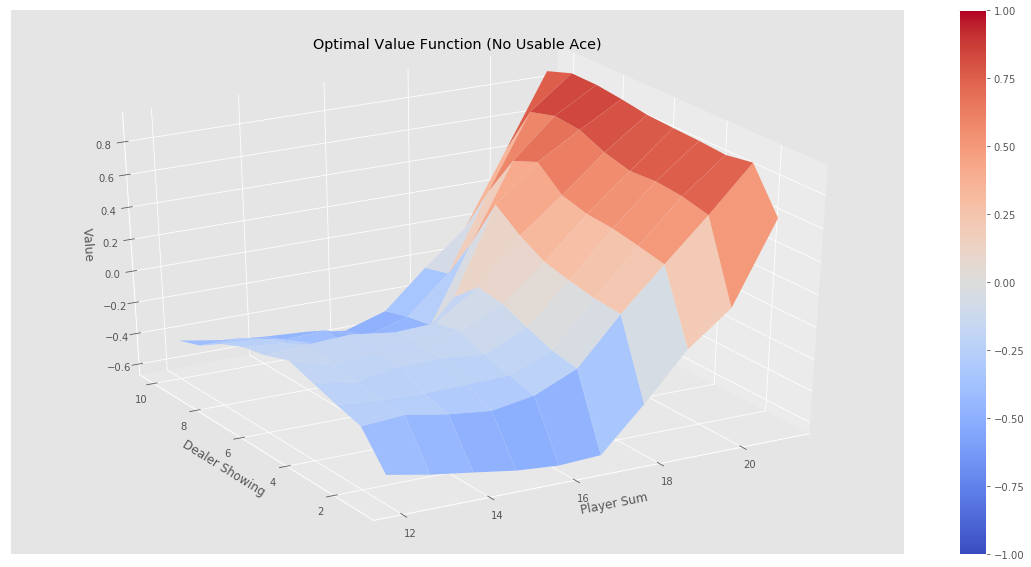

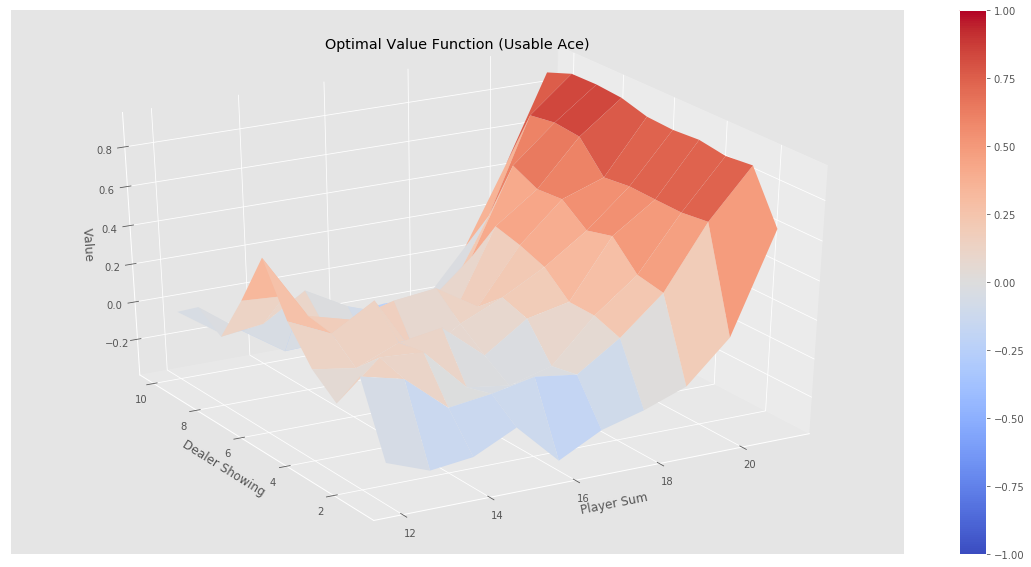

In [7]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")